In [1]:
import xarray as xr
import xrft
import glob
import numpy as np
import matplotlib.pylab as plt
import scipy as sp

#### Start cluster

In [ ]:
import os
os.environ['SGE_ROOT'] = '/opt/sge'

In [ ]:
from distributed import Client, LocalCluster
import dask_jobqueue

# cluster = LocalCluster()

cluster = dask_jobqueue.SGECluster(queue='short',
                                   cores=8,
                                   memory='4GB',
                                   resource_spec='mem_total=8G',
                                   processes=1,
                                   local_directory='$TMPDIR')
cluster.scale(40)

client = Client(cluster)
client

### Compute PSD(x,t) MIOST

#### Read dataset

In [ ]:
ds_miost = xr.open_zarr('/data/MSA_ETU/mballarotta/ETUDE_MIOST/MIOST_PROD_allsat_DT2018_WAVES_PACIFIC_20080101_20181231.zarr')
ds_miost = ds_miost.sel(longitude=slice(180, 280), latitude=slice(-10, 10), drop=True)
ds_miost

#### Rearrange and persist dataset

In [ ]:
adt = ds_miost['Hmeso'] + ds_miost['Htiw'] + ds_miost['Hpoincare'] + ds_miost['MDH']
adt = client.persist(adt)
adt = adt.chunk({'time': -1, 'longitude': -1, 'latitude': 1})
adt['time'] = np.arange(adt.time.size)
adt

#### PSD computation

In [ ]:
psd_xt = xrft.power_spectrum(adt*100, dim=['time', 'longitude'], detrend='constant', window=True)
psd_xt = psd_xt.rename('psd_xt')
mean_psd_xt = psd_xt.mean(dim='latitude')
mean_psd_xt = mean_psd_xt.where((mean_psd_xt.freq_time > 0), drop=True).compute()
mean_psd_xt

In [ ]:
mean_psd_xt.to_netcdf('psd_xt_adt_miost_20080101-20181231.nc')

In [ ]:
del adt
del psd_xt
del mean_psd_xt

### Compute PSD(x,t) DUACS

#### Read dataset

In [ ]:
ds_duacs = xr.open_zarr('/data/MSA_ETU/mballarotta/ETUDE_MIOST/V2018_dt_global_allsat_phy_l4_20080101_20181231.zarr')
ds_duacs = ds_duacs.sel(longitude=slice(180, 280), latitude=slice(-10, 10), drop=True)
ds_duacs

#### Rearrange and persist dataset

In [ ]:
adt = ds_duacs['adt']
adt = client.persist(adt)
adt = adt.chunk({'time': -1, 'longitude': -1, 'latitude': 1})
adt['time'] = np.arange(adt.time.size)
adt

#### PSD computation

In [ ]:
psd_xt = xrft.power_spectrum(adt*100, dim=['time', 'longitude'], detrend='constant', window=True)
psd_xt = psd_xt.rename('psd_xt')
mean_psd_xt = psd_xt.mean(dim='latitude')
mean_psd_xt = mean_psd_xt.where((mean_psd_xt.freq_time > 0), drop=True).compute()
mean_psd_xt

In [ ]:
mean_psd_xt.to_netcdf('psd_xt_adt_duacs_20080101-20181231.nc')

In [ ]:
del adt
del psd_xt
del mean_psd_xt

### Compute PSD(x,t) GLORYS12v1

#### Read dataset

In [ ]:
ds_glorys12v1 = xr.open_zarr('/data/MSA_ETU/mballarotta/ETUDE_MIOST/global-reanalysis-phy-001-030-daily_20080101_20181231.zarr')
ds_glorys12v1 = ds_glorys12v1.sel(longitude=slice(180, 280), latitude=slice(-10, 10), drop=True)
ds_glorys12v1

#### Rearrange and persist dataset

In [ ]:
adt = ds_glorys12v1['zos']
adt = client.persist(adt)
adt = adt.chunk({'time': -1, 'longitude': -1, 'latitude': 1})
adt['time'] = np.arange(adt.time.size)
adt

#### PSD computation

In [ ]:
psd_xt = xrft.power_spectrum(adt*100, dim=['time', 'longitude'], detrend='constant', window=True)
psd_xt = psd_xt.rename('psd_xt')
mean_psd_xt = psd_xt.mean(dim='latitude')
mean_psd_xt = mean_psd_xt.where((mean_psd_xt.freq_time > 0), drop=True).compute()
mean_psd_xt

In [ ]:
mean_psd_xt.to_netcdf('psd_xt_adt_glorys12v1_20080101-20181231.nc')

### PLOT PSD

In [2]:
mean_psd_xt_miost = xr.open_dataset('psd_xt_adt_miost_20080101-20181231.nc')
mean_psd_xt_duacs = xr.open_dataset('psd_xt_adt_duacs_20080101-20181231.nc')
mean_psd_xt_glorys12v1 = xr.open_dataset('psd_xt_adt_glorys12v1_20080101-20181231.nc')

In [3]:
import proplot as plot

In [4]:
def plot_psd():
    
    ZONAL_MIOST = mean_psd_xt_miost.freq_longitude.values
    FREQ_MIOST = mean_psd_xt_miost.freq_time.values
    #PSD_MIOST = sp.ndimage.filters.gaussian_filter(mean_psd_xt_miost.psd_xt.values, [2, 0], mode='constant')
    PSD_MIOST = mean_psd_xt_miost.psd_xt.values
    
    ZONAL_DUACS = mean_psd_xt_duacs.freq_longitude.values
    FREQ_DUACS = mean_psd_xt_duacs.freq_time.values
    #PSD_DUACS = sp.ndimage.filters.gaussian_filter(mean_psd_xt_duacs.psd_xt.values, [2, 0], mode='constant')
    PSD_DUACS = mean_psd_xt_duacs.psd_xt.values
    
    ZONAL_GLORYS12v1 = mean_psd_xt_glorys12v1.freq_longitude.values
    FREQ_GLORYS12v1 = mean_psd_xt_glorys12v1.freq_time.values
    #PSD_GLORYS12v1 = sp.ndimage.filters.gaussian_filter(mean_psd_xt_glorys12v1.psd_xt.values, [2, 0], mode='constant')
    PSD_GLORYS12v1 = mean_psd_xt_glorys12v1.psd_xt.values
    
    vmin = 0.
    vmax = 2
    deltav = 0.25
            
    xtick1 = np.arange(-0.2, 0.25, 0.05)
    ytick1 = np.arange(0., 0.35, 0.05)
    xtick2 = 1./np.ma.masked_where(xtick1 == 0., xtick1)
    ytick2 = 1./np.ma.masked_where(ytick1 == 0., ytick1)
    xtick2 = np.ma.masked_outside(xtick2, -100000000, 100000000).filled(np.inf)
    ytick2 = np.ma.masked_outside(ytick2, -100000000, 100000000).filled(np.inf)

    omega = 7.3*1.e-5
    R = 6371000
    beta = 2*omega/R
    c = 2.7
    kx = ZONAL_MIOST/111000
    n=2
    w = -beta*c*kx/(c*(kx**2)+(2*n+1)*beta)
    w = -beta*kx/((kx**2)+(2*n+1)*beta*c)
    # dispersion relation Equatorial gravity wave
    n = 1
    eq_gravity_wave_n1 = np.sqrt((2*n+1)*beta*c + kx*kx*c*c)*(24*3600)/(2*np.pi)
    n = 2
    eq_gravity_wave_n2 = np.sqrt((2*n+1)*beta*c + kx*kx*c*c)*(24*3600)/(2*np.pi)
    n = 3
    eq_gravity_wave_n3 = np.sqrt((2*n+1)*beta*c + kx*kx*c*c)*(24*3600)/(2*np.pi)
    # dispersion relation for equatorially trapped Kelvin waves
    kelvin_wave = c * kx *(24*3600)/(2*np.pi)
    # dispersion relation for Rossby-poincare wave
    mixed_rossby_poincare = (0.5 * c * kx + np.sqrt(0.25*(kx*c)**2 + beta*c))*(24*3600)/(2*np.pi)
    # dispersion relation rossby wave
    n = 1
    rossby_wave_n1 = -beta*c*kx/(c*(kx**2)+(2*n+1)*beta)*(24*3600)/(2*np.pi)
    n = 2
    rossby_wave_n2 = -beta*c*kx/(c*(kx**2)+(2*n+1)*beta)*(24*3600)/(2*np.pi)
    n = 3
    rossby_wave_n3 = -beta*c*kx/(c*(kx**2)+(2*n+1)*beta)*(24*3600)/(2*np.pi)
    
    def plot_dispersion_relation(ax):
        ax.plot(ZONAL_MIOST/(2*np.pi), eq_gravity_wave_n1, color='w', alpha=0.5)
        ax.plot(ZONAL_MIOST/(2*np.pi), eq_gravity_wave_n2, color='w', alpha=0.5)
        ax.plot(ZONAL_MIOST/(2*np.pi), eq_gravity_wave_n3, color='w', alpha=0.5)
        ax.plot(ZONAL_MIOST/(2*np.pi), kelvin_wave, color='w', alpha=0.5)
        ax.plot(ZONAL_MIOST/(2*np.pi), mixed_rossby_poincare, color='w', alpha=0.5)
        ax.plot(ZONAL_MIOST/(2*np.pi), rossby_wave_n1, color='w', alpha=0.7)
        ax.plot(ZONAL_MIOST/(2*np.pi), rossby_wave_n2, color='w', alpha=0.7)
        ax.plot(ZONAL_MIOST/(2*np.pi), rossby_wave_n3, color='w', alpha=0.7)
        
    cmap='Spectral_r'
    cmap='jet'
    cmap='nipy_spectral'
    #fig = plt.figure(figsize=(15, 12))
    fig = plt.figure(figsize=(10, 6))
    
    plt.subplots_adjust(wspace=0.5)
        
    ax1 = fig.add_subplot(131)
    cs = plt.contourf(ZONAL_DUACS, FREQ_DUACS, np.log10(PSD_DUACS[:, ::-1]), cmap=cmap, levels=np.arange(vmin, vmax+deltav, deltav), extend='both') 
    #cs = plt.pcolormesh(ZONAL1, FREQ, np.log10(PSD), cmap='Spectral_r', vmin=-2, vmax=3.4)#, levels=np.arange(-2, 3, 0.01), extend='both')
    cb = plt.colorbar(cs, orientation='horizontal', pad=0.1)
    cb.set_ticks(np.arange(-2, 3, 1))
    cb.set_label('Log$_{10}$ of spectral density (cm$^{2}$/cpd/deg$^{-1}$)')
    plot_dispersion_relation(ax1)
    plt.axvline(x=0., linewidth=1, color='k')
    plt.xlabel("Zonal wavenumber (deg$^{-1}$)", fontweight='bold')
    plt.ylabel('Frequency (cpd)', fontweight='bold')
    ax1.set_xlim(-0.2, 0.2, 0.05)
    ax1.set_ylim(0, 0.3, 0.05)
    ax1.grid()
    ax2 = ax1.twiny()
    ax2.set_xticks(xtick1)
    xtick2_string = ["%2.0f" % x for x in xtick2]
    ax2.set_xticklabels(xtick2_string)
    ax2.set_xlabel("Zonal wavenumber (deg.)", fontweight='bold')
    ax2.set_xlim(-0.2, 0.2, 0.05)
    ax3 = ax1.twinx()
    ax3.set_yticks(ytick1)
    ytick2_string = ["%2.0f" % y for y in ytick2]
    ax3.set_yticklabels(ytick2_string)
    ax3.set_ylabel("Period (days)", fontweight='bold')
    ax3.set_ylim(0, 0.3, 0.05)
    plt.title('DUACS')
    
    ax1 = fig.add_subplot(132)
    cs = plt.contourf(ZONAL_MIOST, FREQ_MIOST, np.log10(PSD_MIOST[:, ::-1]), cmap=cmap, levels=np.arange(vmin, vmax+deltav, deltav), extend='both') 
    cb = plt.colorbar(cs, orientation='horizontal', pad=0.1)
    cb.set_ticks(np.arange(-2, 3, 1))
    cb.set_label('Log$_{10}$ of spectral density (cm$^{2}$/cpd/deg$^{-1}$)')
    plot_dispersion_relation(ax1)
    plt.axvline(x=0., linewidth=1, color='k')
    plt.xlabel("Zonal wavenumber (deg$^{-1}$)", fontweight='bold')
    plt.ylabel('Frequency (cpd)', fontweight='bold')
    ax1.set_xlim(-0.2, 0.2, 0.05)
    ax1.set_ylim(0, 0.3, 0.05)
    ax1.grid()
    ax2 = ax1.twiny()
    ax2.set_xticks(xtick1)
    xtick2_string = ["%2.0f" % x for x in xtick2]
    ax2.set_xticklabels(xtick2_string)
    ax2.set_xlabel("Zonal wavenumber (deg.)", fontweight='bold')
    ax2.set_xlim(-0.2, 0.2, 0.05)
    ax3 = ax1.twinx()
    ax3.set_yticks(ytick1)
    ytick2_string = ["%2.0f" % y for y in ytick2]
    ax3.set_yticklabels(ytick2_string)
    ax3.set_ylabel("Period (days)", fontweight='bold')
    ax3.set_ylim(0, 0.3, 0.05)
    plt.title('MIOST')
    
    ax1 = fig.add_subplot(133)
    cs = plt.contourf(ZONAL_GLORYS12v1, FREQ_GLORYS12v1, np.log10(PSD_GLORYS12v1[:, ::-1]), cmap=cmap, levels=np.arange(vmin, vmax+deltav, deltav), extend='both') 
    cb = plt.colorbar(cs, orientation='horizontal', pad=0.1)
    cb.set_ticks(np.arange(-2, 3, 1))
    cb.set_label('Log$_{10}$ of spectral density (cm$^{2}$/cpd/deg$^{-1}$)')
    plot_dispersion_relation(ax1)
    plt.axvline(x=0., linewidth=1, color='k')
    plt.xlabel("Zonal wavenumber (deg$^{-1}$)", fontweight='bold')
    plt.ylabel('Frequency (cpd)', fontweight='bold')
    ax1.set_xlim(-0.2, 0.2, 0.05)
    ax1.set_ylim(0, 0.3, 0.05)
    ax1.grid()
    ax2 = ax1.twiny()
    ax2.set_xticks(xtick1)
    xtick2_string = ["%2.0f" % x for x in xtick2]
    ax2.set_xticklabels(xtick2_string)
    ax2.set_xlabel("Zonal wavenumber (deg.)", fontweight='bold')
    ax2.set_xlim(-0.2, 0.2, 0.05)
    ax3 = ax1.twinx()
    ax3.set_yticks(ytick1)
    ytick2_string = ["%2.0f" % y for y in ytick2]
    ax3.set_yticklabels(ytick2_string)
    ax3.set_ylabel("Period (days)", fontweight='bold')
    ax3.set_ylim(0, 0.3, 0.05)
    plt.title('GLORYS12v1')
    
    plt.savefig('psd_xt_miost_waves_duacs_glorys12v1_2008-2018.png', dpi=100, facecolor=fig.get_facecolor(), transparent=True, bbox_inches='tight')


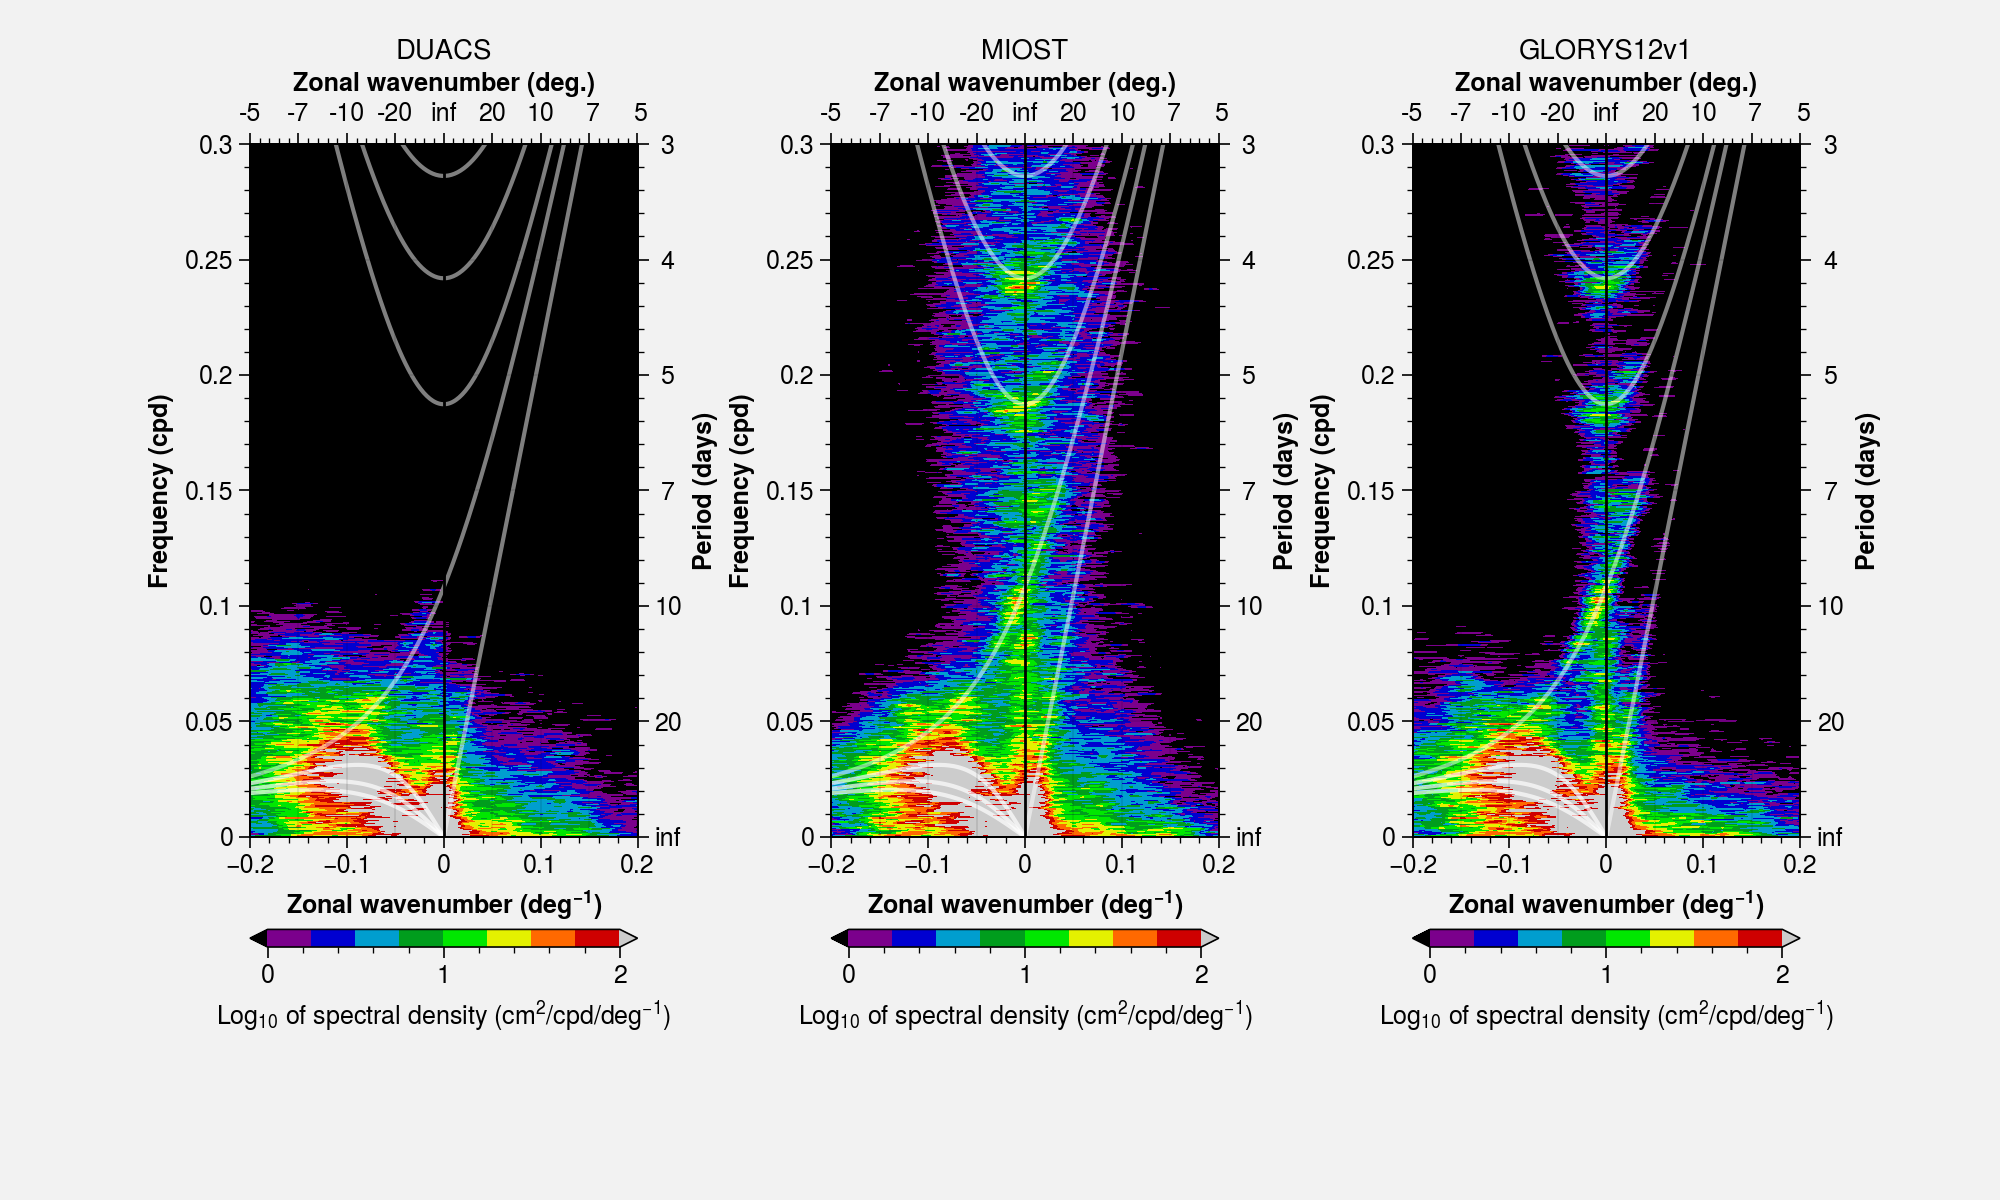

In [5]:
plot_psd()

In [ ]:
client.close()
cluster.close()